## Training a 1d convolutional model on RAVDESS audio datasets
We import the datasets and create pandas dataframes as in www.kaggle.com/code/llhvglbmlf/capstone-aiml.

Samples labelled as 'surprised' or label 8 are dropped as they serve no useful purpose in this case.

We end up with 2260 samples, data is given by a filepath and a binary 0 (positive affect) or 1 (negative affect) label.

In [4]:
# adapated from https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data
import kagglehub, librosa, tensorflow as tf
import os, pandas as pd, matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import (Conv1D,BatchNormalization, Dropout, Flatten, Dense, Input,GlobalAveragePooling1D, MaxPool1D)
from tensorflow.keras import initializers, layers, models
print(tf.__version__)  # should show 2.15.0

path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
path2 = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-song-audio")

# adapated from https://www.kaggle.com/code/llhvglbmlf/capstone-aiml
F, L = [], []

# parse the paths and file names for emotion identifiers
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        label = filename[::-1].split('_')[0][::-1]
        k=int(label[7:8])
        if k!=8:
            F.append(os.path.join(dirname, filename))
            if k<=3:
                L.append(0)
            else:
                L.append(1)

for dirname, _, filenames in os.walk(path2):
    for filename in filenames:
        label = filename[::+-1].split('_')[0][::-1]
        k=int(label[7:8])
        if k!=8:
            F.append(os.path.join(dirname, filename))
            if k<=3:
                L.append(0)
            else:
                L.append(1)
        
data=pd.DataFrame({'files':F, 'labels':L})
classes=['positive','negative']

# now we have one numpy array containing the paths and their labels
full=np.array((data.files,data.labels)).T
Labels=np.ascontiguousarray(full.T[1],dtype=np.int32)

print(full.shape)
print(Labels.shape)

2.15.0
Resuming download from 101711872 bytes (375929798 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/uwrfkaggler/ravdess-emotional-song-audio?dataset_version_number=1 (101711872/477641670) bytes left.


100%|██████████| 456M/456M [01:30<00:00, 4.15MB/s]

Extracting files...


(4520, 2)
(4520,)


## Waveform visualization

The following waveform depictions are included to display the original intent of the training: we wanted to train a 2d convolutional model on the images of these waveforms, but this did not work out.

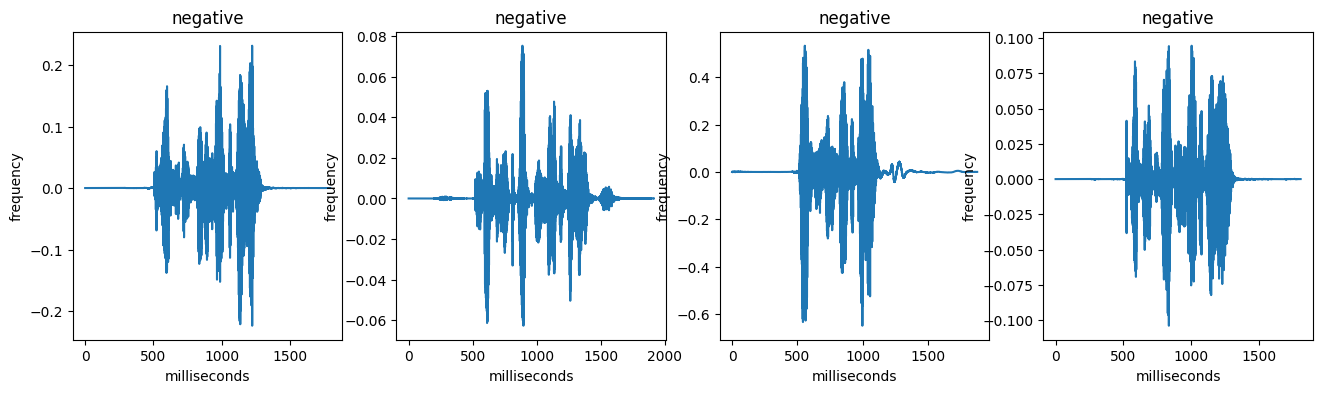

In [9]:
# let's see a few examples of waveforms

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
l=22050

for i in range(4):
    audio,label=full[i*100]
    y, sr = librosa.load(audio, sr=l)
    X = librosa.times_like(y)
    axs[i].plot(X, y)
    axs[i].set_title(classes[label])
    axs[i].set_xlabel('milliseconds')
    axs[i].set_ylabel('frequency')

## Feature extraction

Using librosa, we parse each sample for its audio features using a 5 second duration and 22.05 kHz sampling rate.

Due to the small size of the dataset, we take an 80-10-10 train-val-test split. There is a slight class imbalance favouring the negative samples, but this is reflected in both train and validation splits. It is also expected since the neutral emotion had fewer samples in the dataset, and we assigned neutral to the positive affect.

In [11]:
sr=22050
dur=5
clip_len=dur*sr

audio_features=[]
targets=[]

dataset_paths=full.T[0]
labels=full.T[1]

for file,label in zip(dataset_paths,labels):
    audio, sr = librosa.load(file, sr=22050, mono=True)
    audio = audio / (np.max(np.abs(audio)) + 1e-6)

    if len(audio)<clip_len:
        audio=np.pad(audio,(0,clip_len-len(audio)))
    else:
        audio=audio[:clip_len]
    
    audio_features.append(audio)
    targets.append(label)
    
audio_features,targets=np.array(audio_features),np.array(targets)

audio_features=audio_features.reshape(len(labels),sr*dur,1)

train_data,test_data,train_labels,test_labels=train_test_split(audio_features,targets,test_size=0.2)
val_data,test_data,val_labels,test_labels=train_test_split(test_data,test_labels,test_size=0.5)

# slight class imbalance favouring negative samples
print('Train split class distribution:', np.bincount(train_labels.astype(int)))
print('Val split class distribution:', np.bincount(val_labels.astype(int)))

Train split class distribution: [1502 2114]
Val split class distribution: [185 267]


## Training

Using tensorflow, we train a relatively simple 1d convolutional model with 3 convolutional blocks, one linear layer, ending with a single sigmoid-activated neuron. Practically, we can interpret the output of the model as a confidence/likelihood that the observed sample belongs to label 1: negative. Thus we can consider 100-prediction to be a confidence/likelihood that the observed sample belongs to label 0: positive. The raw output of thismodel is effectively a negative emotion predictor.

Note that we choose an unaltered Adam lr 0.001 optimizer and a binary cross entropy loss. We also record all metrics, including a checkpoint callback. We do not include an early stop callback for the purpose of visualizing the when the model begins to overfit.

In [12]:
model = keras.Sequential([
    Input((clip_len, 1)),
    Conv1D(16,60,2,padding='same',activation='relu'),
    keras.layers.MaxPool1D(4),
    keras.layers.Dropout(0.2),

    keras.layers.Conv1D(32,16,2,padding='same',activation='relu'),
    keras.layers.MaxPool1D(4),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv1D(64,8,2,padding='same',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(4),
    
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='audio1dconv.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)

history=model.fit(
    x=train_data,
    y=train_labels,
    validation_data=(val_data,val_labels),
    epochs=60,
    batch_size=16,
    callbacks=checkpoint)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55125, 16)         976       
                                                                 
 max_pooling1d (MaxPooling1  (None, 13781, 16)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13781, 16)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6891, 32)          8224      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1722, 32)          0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1722, 32)          0

2025-12-06 21:46:20.904449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-06 21:46:20.949008: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/60
225/226 [============================>.] - ETA: 0s - loss: 0.6486 - accuracy: 0.6244
Epoch 1: val_loss improved from inf to 0.64533, saving model to audio1dconv.keras
226/226 [==============================] - 12s 51ms/step - loss: 0.6482 - accuracy: 0.6247 - val_loss: 0.6453 - val_accuracy: 0.6704
Epoch 2/60
226/226 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.6897
Epoch 2: val_loss improved from 0.64533 to 0.54882, saving model to audio1dconv.keras
226/226 [==============================] - 10s 46ms/step - loss: 0.5801 - accuracy: 0.6897 - val_loss: 0.5488 - val_accuracy: 0.7323
Epoch 3/60
226/226 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.7790
Epoch 3: val_loss did not improve from 0.54882
226/226 [==============================] - 10s 45ms/step - loss: 0.4776 - accuracy: 0.7790 - val_loss: 0.6995 - val_accuracy: 0.6836
Epoch 4/60
225/226 [============================>.] - ETA: 0s - loss: 0.4169 - accuracy: 0.8089
Ep

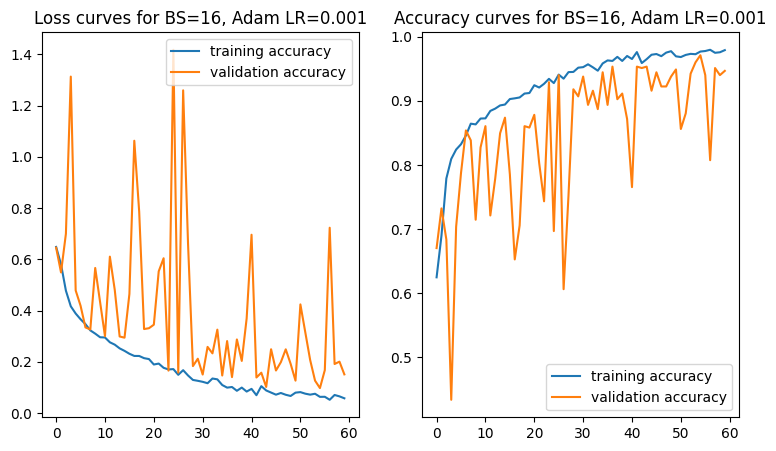

In [13]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(9,5))

axs[0].plot([i for i in range(60)],history.history['loss'],label='training accuracy')
axs[0].plot([i for i in range(60)],history.history['val_loss'],label='validation accuracy')
axs[0].set_title('Loss curves for BS=16, Adam LR=0.001')
axs[0].legend()
axs[1].plot([i for i in range(60)],history.history['accuracy'],label='training accuracy')
axs[1].plot([i for i in range(60)],history.history['val_accuracy'],label='validation accuracy')
axs[1].set_title('Accuracy curves for BS=16, Adam LR=0.001')
axs[1].legend()